In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

## Merged original training and testing set to apply K-Fold 

In [ ]:
train = "./DS/iec104_custom_script_train_final.csv"
test = "./DS/iec104_custom_script_test_final.csv"
output_file = "./DS/original_ds.csv"

df1 = pd.read_csv(train)
df2 = pd.read_csv(test)

merged_df = pd.concat([df1, df2], ignore_index=True)

merged_df.to_csv(output_file, index=False)


## K-Fold

In [11]:
def multiclass_kfold_cv(X, y, model, n_splits=5):
    """Multi-class K-Fold Cross-Validation"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Metrics storage
    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    
    # Track best fold
    best_fold = -1
    best_f1_score = -np.inf
    best_train_index, best_val_index = None, None
    
    # Detailed per-fold tracking
    class_reports = []
    confusion_matrices = []
    
    for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
        # Data split
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        # Model training
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        # Metrics calculation
        f1 = f1_score(y_val, y_pred, average='weighted')
        metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['precision'].append(precision_score(y_val, y_pred, average='weighted'))
        metrics['recall'].append(recall_score(y_val, y_pred, average='weighted'))
        metrics['f1_score'].append(f1)
        
        # Check if this fold is the best
        if f1 > best_f1_score:
            best_f1_score = f1
            best_fold = fold
            best_train_index, best_val_index = train_index, val_index
        
        # Detailed reports
        class_reports.append(classification_report(y_val, y_pred, output_dict=True))
        confusion_matrices.append(confusion_matrix(y_val, y_pred))
        
        # Print fold results
        print(f"Fold {fold} Results:")
        print(classification_report(y_val, y_pred))
    
    # Save best fold's data to CSV
    if best_fold != -1:
        best_X_train, best_X_val = X.iloc[best_train_index], X.iloc[best_val_index]
        best_y_train, best_y_val = y.iloc[best_train_index], y.iloc[best_val_index]
        
        train_data = pd.concat([best_X_train, best_y_train.rename("Label")], axis=1)
        test_data = pd.concat([best_X_val, best_y_val.rename("Label")], axis=1)
        
        train_data.to_csv(f"./DS/train_fold_{best_fold}.csv", index=False)
        test_data.to_csv(f"./DS/test_fold_{best_fold}.csv", index=False)
        
        print(f"Best fold: {best_fold} | F1-Score: {best_f1_score:.4f}")
        print(f"Best train and test datasets saved as train_fold_{best_fold}.csv and test_fold_{best_fold}.csv")
    
    # Summary statistics
    summary = {k: {'mean': np.mean(v), 'std': np.std(v)} for k, v in metrics.items()}
    
    # Visualization of confusion matrices
    plt.figure(figsize=(15, 3*n_splits))
    for i in range(n_splits):
        plt.subplot(1, n_splits, i+1)
        sns.heatmap(confusion_matrices[i], annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - Fold {i+1}')
    plt.tight_layout()
    plt.show()
    
    return summary, class_reports

/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold 1 Results:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       102
         1.0       0.84      0.83      0.83       115
         2.0       0.79      0.84      0.81       138
         3.0       0.78      0.70      0.73       125
         4.0       0.68      0.74      0.71       108
         5.0       1.00      1.00      1.00       125
         6.0       0.71      0.74      0.73       108
         7.0       0.64      0.59      0.62       116
         8.0       0.76      0.79      0.78       102
         9.0       0.56      0.56      0.56       107
        10.0       0.57      0.57      0.57       120
        11.0       1.00      1.00      1.00       100

    accuracy                           0.78      1366
   macro avg       0.78      0.78      0.78      1366
weighted avg       0.78      0.78      0.78      1366

Fold 2 Results:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   

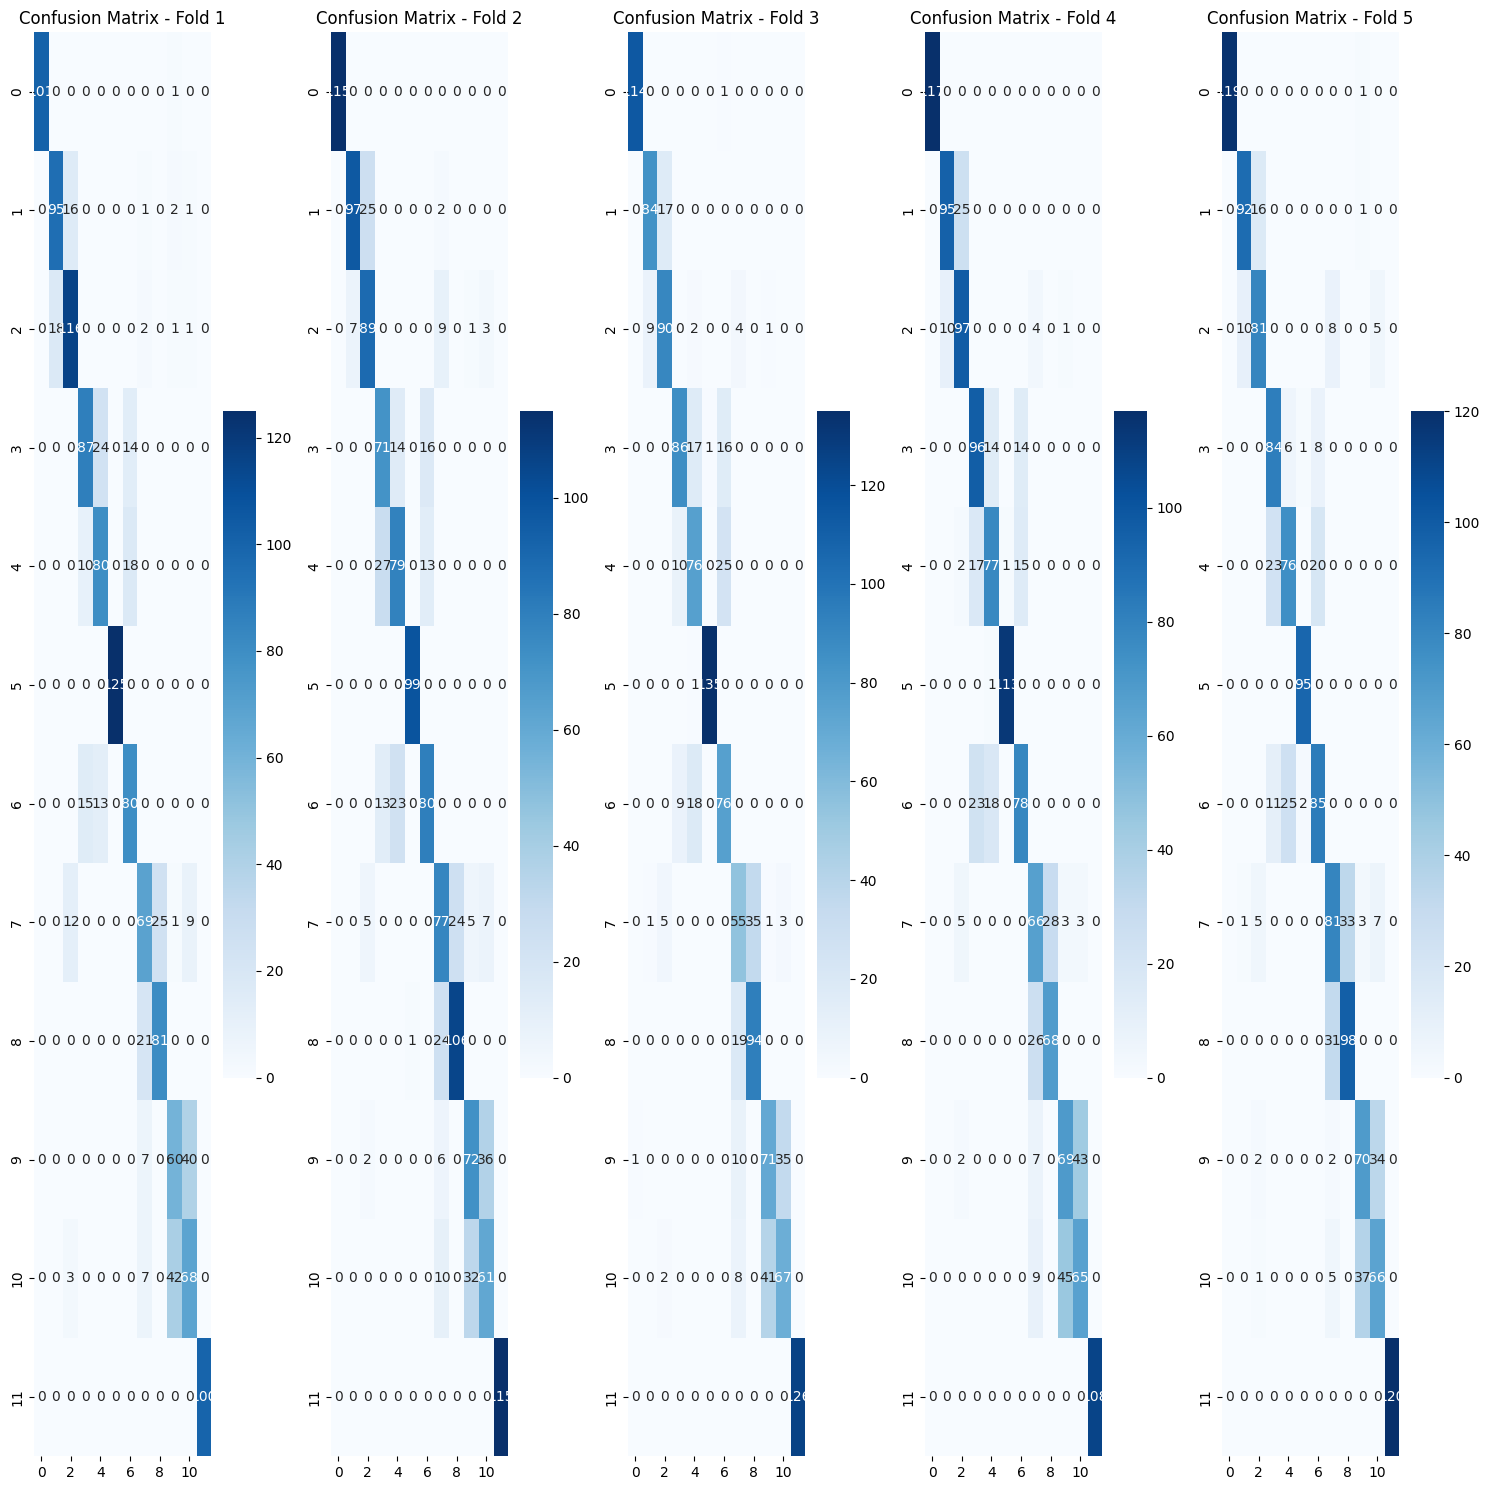


Cross-Validation Summary:
Accuracy: 0.7781 (±0.0059)
Precision: 0.7797 (±0.0058)
Recall: 0.7781 (±0.0059)
F1_score: 0.7780 (±0.0058)


In [12]:
# Data preparation
original_ds = pd.read_csv('./DS/original_ds.csv')
X = original_ds.drop('Label', axis=1)
y = original_ds['Label']
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y).astype(np.float32)
y = pd.Series(y)

# XGBoost multi-class classifier
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Perform cross-validation
cv_summary, detailed_reports = multiclass_kfold_cv(X, y, model)

# Print summary
print("\nCross-Validation Summary:")
for metric, stats in cv_summary.items():
    print(f"{metric.capitalize()}: {stats['mean']:.4f} (±{stats['std']:.4f})")